In [20]:
#I import the packages I'll use for this project

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
from sklearn.model_selection import train_test_split

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder, MinMaxScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.activations import relu, sigmoid
from tensorflow.keras.metrics import Precision, Recall
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [21]:
#I wanted to read the five first rows

ChurnP = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
ChurnP.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [22]:
#For the three next cells, I'd like to inspect the dataset

ChurnP.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [23]:
ChurnP.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [24]:
ChurnP.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [25]:
#TotalCharges should normaly be a numeric type, so I change it

ChurnP['TotalCharges'] = pd.to_numeric(ChurnP['TotalCharges'],  errors='coerce')
ChurnP['TotalCharges'].dtypes

dtype('float64')

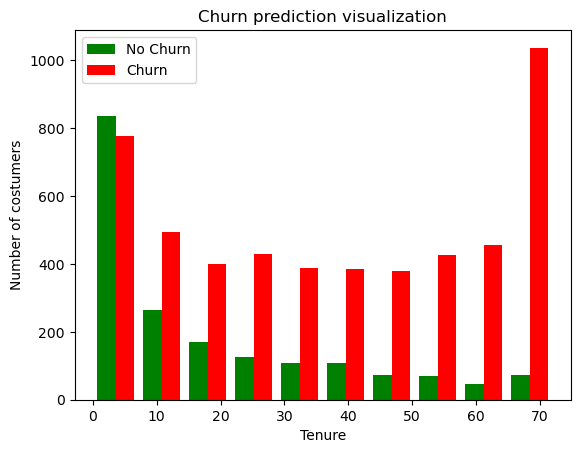

In [26]:
#Wanted to do the EDA of the data before any implementation model

Churn_is_Yes = ChurnP[ChurnP['Churn'] == 'Yes'].tenure
Churn_is_No = ChurnP[ChurnP['Churn'] == 'No'].tenure

plt.hist([Churn_is_Yes, Churn_is_No], bins=10,color=['green','red'], label=['No Churn', 'Churn'])
plt.legend()
plt.xlabel('Tenure')
plt.ylabel('Number of costumers')
plt.title('Churn prediction visualization')
plt.show()

In [27]:
#This function assist me verifying whichs colons I must apply the encoder

def the_unique_values_print(ChurnP):
    for col in ChurnP:
        if ChurnP[col].dtypes == 'object':
            print(f'{col} : {ChurnP[col].unique()}')

In [28]:
#I've noticed that the custumerID amount to anything so it should be dropped

ChurnP.drop(columns=['customerID'], inplace=True)
the_unique_values_print(ChurnP)

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No phone service' 'No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes' 'No internet service']
OnlineBackup : ['Yes' 'No' 'No internet service']
DeviceProtection : ['No' 'Yes' 'No internet service']
TechSupport : ['No' 'Yes' 'No internet service']
StreamingTV : ['No' 'Yes' 'No internet service']
StreamingMovies : ['No' 'Yes' 'No internet service']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [29]:
#Making sure that the cathegorical columns are coherent

ChurnP.replace('No phone service', 'No', inplace=True)
ChurnP.replace('No internet service', 'No', inplace=True)

the_unique_values_print(ChurnP)

gender : ['Female' 'Male']
Partner : ['Yes' 'No']
Dependents : ['No' 'Yes']
PhoneService : ['No' 'Yes']
MultipleLines : ['No' 'Yes']
InternetService : ['DSL' 'Fiber optic' 'No']
OnlineSecurity : ['No' 'Yes']
OnlineBackup : ['Yes' 'No']
DeviceProtection : ['No' 'Yes']
TechSupport : ['No' 'Yes']
StreamingTV : ['No' 'Yes']
StreamingMovies : ['No' 'Yes']
Contract : ['Month-to-month' 'One year' 'Two year']
PaperlessBilling : ['Yes' 'No']
PaymentMethod : ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn : ['No' 'Yes']


In [30]:
#Separating the dataset to features and target

x = ChurnP.drop(['Churn'], axis = 1)
y = ChurnP['Churn']

In [31]:
#Encoding the label y

label_churn = LabelEncoder()
y = label_churn.fit_transform(y)

In [32]:
#Encoding the feature x

Yes_No_Col = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
              'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 
              'StreamingTV', 'StreamingMovies', 'PaperlessBilling','InternetService','Contract','PaymentMethod']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), Yes_No_Col),
        ('num', MinMaxScaler(), ['tenure', 'MonthlyCharges', 'TotalCharges'])
    ], 
    remainder='passthrough' 
)

preprocessor.set_output(transform="pandas")

features_churn = preprocessor.fit_transform(x)
features_churn = features_churn.astype('float32')

X = features_churn

In [33]:
#Printing the result of the encoder

print(features_churn.head())

   cat__gender_Male  cat__Partner_Yes  cat__Dependents_Yes  \
0               0.0               1.0                  0.0   
1               1.0               0.0                  0.0   
2               1.0               0.0                  0.0   
3               1.0               0.0                  0.0   
4               0.0               0.0                  0.0   

   cat__PhoneService_Yes  cat__MultipleLines_Yes  cat__OnlineSecurity_Yes  \
0                    0.0                     0.0                      0.0   
1                    1.0                     0.0                      1.0   
2                    1.0                     0.0                      1.0   
3                    0.0                     0.0                      1.0   
4                    1.0                     0.0                      0.0   

   cat__OnlineBackup_Yes  cat__DeviceProtection_Yes  cat__TechSupport_Yes  \
0                    1.0                        0.0                   0.0   
1         

In [34]:
#split the data before applying a model

x_train,x_test,y_train,y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [35]:
#Training the model using RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(x_train, y_train)

RandomForestClassifier(random_state=42)

In [37]:
#Evaluate the RandomForestClassifier

y_pred_rf = rf_model.predict(x_test)
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1036
           1       0.67      0.48      0.56       373

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.71      1409
weighted avg       0.79      0.80      0.79      1409



In [40]:
#Training the model using neural network to compare the result

model = Sequential([
    Dense(60, activation='relu'),
    Dense(40, activation='relu'),
    Dense(20, activation='relu'),
    Dense(1, activation='sigmoid'),
])

model.compile( 
             optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
             loss=BinaryCrossentropy(),
             metrics=['accuracy'])

model.fit(x_train,y_train, epochs=50)

Epoch 1/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7345 - loss: 0.6053
Epoch 2/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5793
Epoch 3/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5790
Epoch 4/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5795
Epoch 5/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5792
Epoch 6/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5790
Epoch 7/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5791
Epoch 8/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5792
Epoch 9/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5794
Epoch 10/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5794
Epoch 11/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7345 - loss: 0.5791
Epoch 12/50
177/177 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

In [42]:
#Evaluate the model

model.evaluate(x_test, y_test)

45/45 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7353 - loss: 0.5779


[0.5779440402984619, 0.7352732419967651]

### Model Comparison and Analysis
I noticed that the **Random Forest** model achieved an accuracy of **80%**, whereas the **Neural Network** reached approximately **73%**. 

This difference illustrates that for this specific tabular dataset, the Random Forest method is more efficient and robust. It highlights a key machine learning principle: simpler, tree-based models often outperform deep learning architectures on structured data with limited samples.


In [45]:

import joblib

joblib.dump(preprocessor, "preprocessor.pkl")
joblib.dump(model, "Churn_Prediction_Project.pkl")


['Churn_Prediction_Project.pkl']